# Shahabas KM - Stock Price Prediction using Textual and Historical Data

In [1]:
# Import the libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import nltk
import re
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
import lightgbm

## Loading the news dataset

In [2]:

ndf = pd.read_csv("D:\ML Projects\Stock Price Prediction - Manchester United\india-news-headlines.csv")

In [3]:
ndf.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [4]:
ndf.drop('headline_category', axis=1, inplace=True)

Here i removed the column named category

In [5]:
ndf.head()

,publish_date,headline_text
0,20010102,Status quo will not be disturbed at Ayodhya; s...
1,20010102,Fissures in Hurriyat over Pak visit
2,20010102,America's unwanted heading for India?
3,20010102,For bigwigs; it is destination Goa
4,20010102,Extra buses to clear tourist traffic


In [6]:
ndf.info() # here the datatype of date is int, which we will have to covert into datetime format

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 0 to 3650969
Data columns (total 2 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   publish_date   int64 
 1   headline_text  object
dtypes: int64(1), object(1)
memory usage: 55.7+ MB


In [7]:
ndf.rename(columns={'publish_date': 'Date'}, inplace=True)

In [8]:
ndf["Date"] = pd.to_datetime(ndf["Date"],format='%Y%m%d')
ndf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 0 to 3650969
Data columns (total 2 columns):
 #   Column         Dtype         
---  ------         -----         
 0   Date           datetime64[ns]
 1   headline_text  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 55.7+ MB


In [9]:
ndf['headline_text'] = ndf.groupby(['Date']).transform(lambda x : ' '.join(x)) 
ndf = ndf.drop_duplicates() 
ndf.reset_index(inplace=True,drop=True)

In [10]:
ndf

,Date,headline_text
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
7712,2022-03-27,Playing a dead man in Body God meant sitting i...
7713,2022-03-28,As fashion becomes democratic; demand for styl...
7714,2022-03-29,Bobby Deol: Like my dad; I hope to be working ...
7715,2022-03-30,I will not give in to trends: Dossmode The tim...


In [11]:
# Check for any duplicated values
ndf.isnull().sum()

Date             0
headline_text    0
dtype: int64

In [12]:
#Cleaning news data for sentiment analysis
#removing unwanted characters from the News
ndf.replace("[^a-zA-Z']"," ",regex=True,inplace=True)
ndf["headline_text"].head(5)

0    Status quo will not be disturbed at Ayodhya  s...
1    Powerless north India gropes in the dark Think...
2    The string that pulled Stephen Hawking to Indi...
3    Light combat craft takes India into club class...
4    Light combat craft takes India into club class...
Name: headline_text, dtype: object

## Loading the historical dataset of Manchester United

In [13]:
mandf = pd.read_csv("D:\ML Projects\Stock Price Prediction - Manchester United\MANU.csv")

In [14]:
mandf.head(-5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,10-08-2012,14.050000,14.200000,14.000000,14.000000,12.978291,31846200
1,13-08-2012,13.970000,15.270000,13.960000,14.150000,13.117345,2061800
2,14-08-2012,14.200000,14.480000,14.150000,14.200000,13.163694,204800
3,15-08-2012,14.420000,14.880000,14.030000,14.050000,13.024641,563500
4,16-08-2012,14.070000,14.080000,13.290000,13.770000,12.765076,1605600
...,...,...,...,...,...,...,...
2795,21-09-2023,18.719999,18.830000,18.180000,18.270000,18.270000,996700
2796,22-09-2023,18.639999,18.879999,18.340000,18.580000,18.580000,378700
2797,25-09-2023,18.500000,19.910000,18.500000,19.360001,19.360001,983200
2798,26-09-2023,19.590000,20.049999,19.299999,19.410000,19.410000,935600


In [15]:
mandf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2805 entries, 0 to 2804
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2805 non-null   object 
 1   Open       2805 non-null   float64
 2   High       2805 non-null   float64
 3   Low        2805 non-null   float64
 4   Close      2805 non-null   float64
 5   Adj Close  2805 non-null   float64
 6   Volume     2805 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 153.5+ KB


In [16]:
# changing the datatype of date
mandf["Date"]= pd.to_datetime(mandf["Date"])
mandf["Volume"]= mandf["Volume"].astype(float)

In [17]:
mandf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2805 entries, 0 to 2804
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2805 non-null   datetime64[ns]
 1   Open       2805 non-null   float64       
 2   High       2805 non-null   float64       
 3   Low        2805 non-null   float64       
 4   Close      2805 non-null   float64       
 5   Adj Close  2805 non-null   float64       
 6   Volume     2805 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 153.5 KB


In [18]:
mandf.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [19]:
mandf.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2.805000e+03
mean,17.082806,17.326688,16.836389,17.069062,16.329109,3.032434e+05
std,2.633399,2.706323,2.573970,2.637930,2.655796,1.177221e+06
min,10.480000,10.660000,10.410000,10.510000,10.510000,0.000000e+00
25%,15.550000,15.750000,15.350000,15.510000,14.702548,2.970000e+04
50%,16.770000,17.000000,16.549999,16.770000,15.834856,6.710000e+04
75%,18.480000,18.750000,18.190001,18.469999,17.581194,2.318000e+05
max,27.000000,27.700001,26.000000,26.840000,26.840000,3.522620e+07


## Plotting the figures

## Line Chart

Text(0, 0.5, 'Stock price')

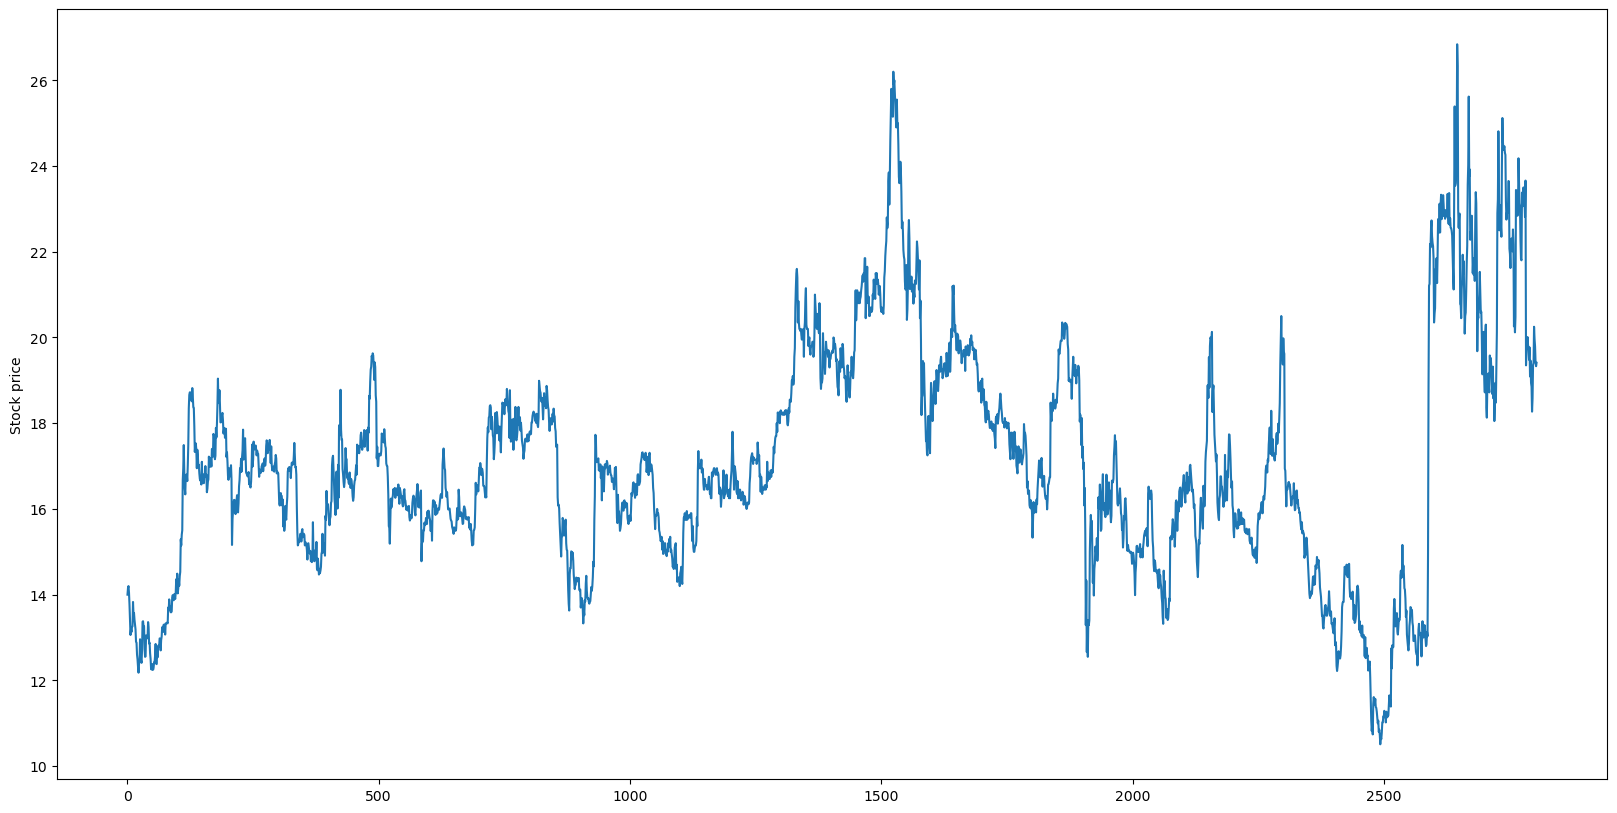

In [20]:
plt.figure(figsize=(20,10))
mandf['Close'].plot()
plt.ylabel('Stock price')

## Candle Chart

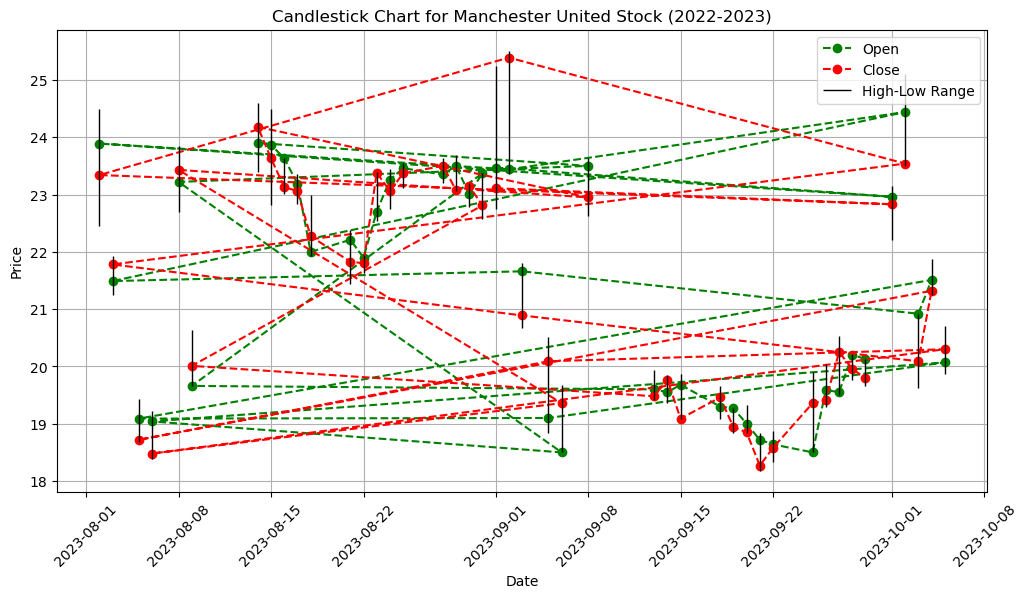

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Filter "mandf" for the desired date range
start_date = '2023-08-01'
end_date = '2023-10-05'
filtered_mandf = mandf[(mandf['Date'] >= start_date) & (mandf['Date'] <= end_date)]

# Create the candlestick chart
fig, ax = plt.subplots(figsize=(12, 6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.plot(filtered_mandf['Date'], filtered_mandf['Open'], label='Open', color='green', linestyle='--', marker='o')
ax.plot(filtered_mandf['Date'], filtered_mandf['Close'], label='Close', color='red', linestyle='--', marker='o')
ax.vlines(filtered_mandf['Date'], filtered_mandf['Low'], filtered_mandf['High'], color='black', linewidth=1, label='High-Low Range')

ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Candlestick Chart for Manchester United Stock (2022-2023)')
ax.legend()
ax.grid(True)

plt.xticks(rotation=45)
plt.show()


## Moving averages 

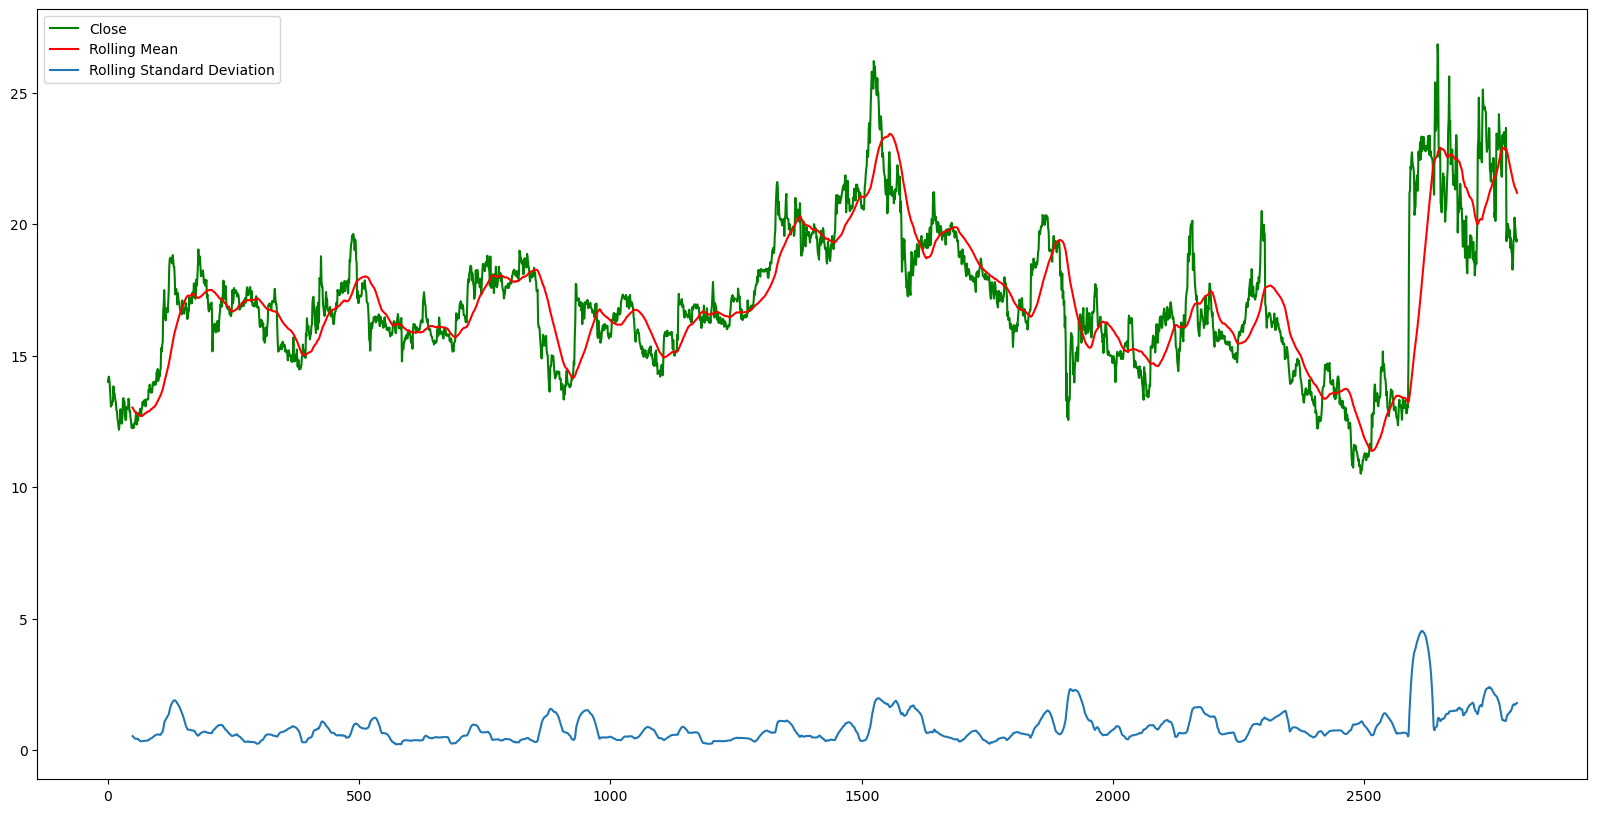

In [22]:
#Plotting moving average
close = mandf['Close']

ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(20,10))
mandf['Close'].plot(color='g',label='Close')
ma.plot(color = 'r',label='Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')

plt.legend()

Text(0.5, 1.0, 'Returns')

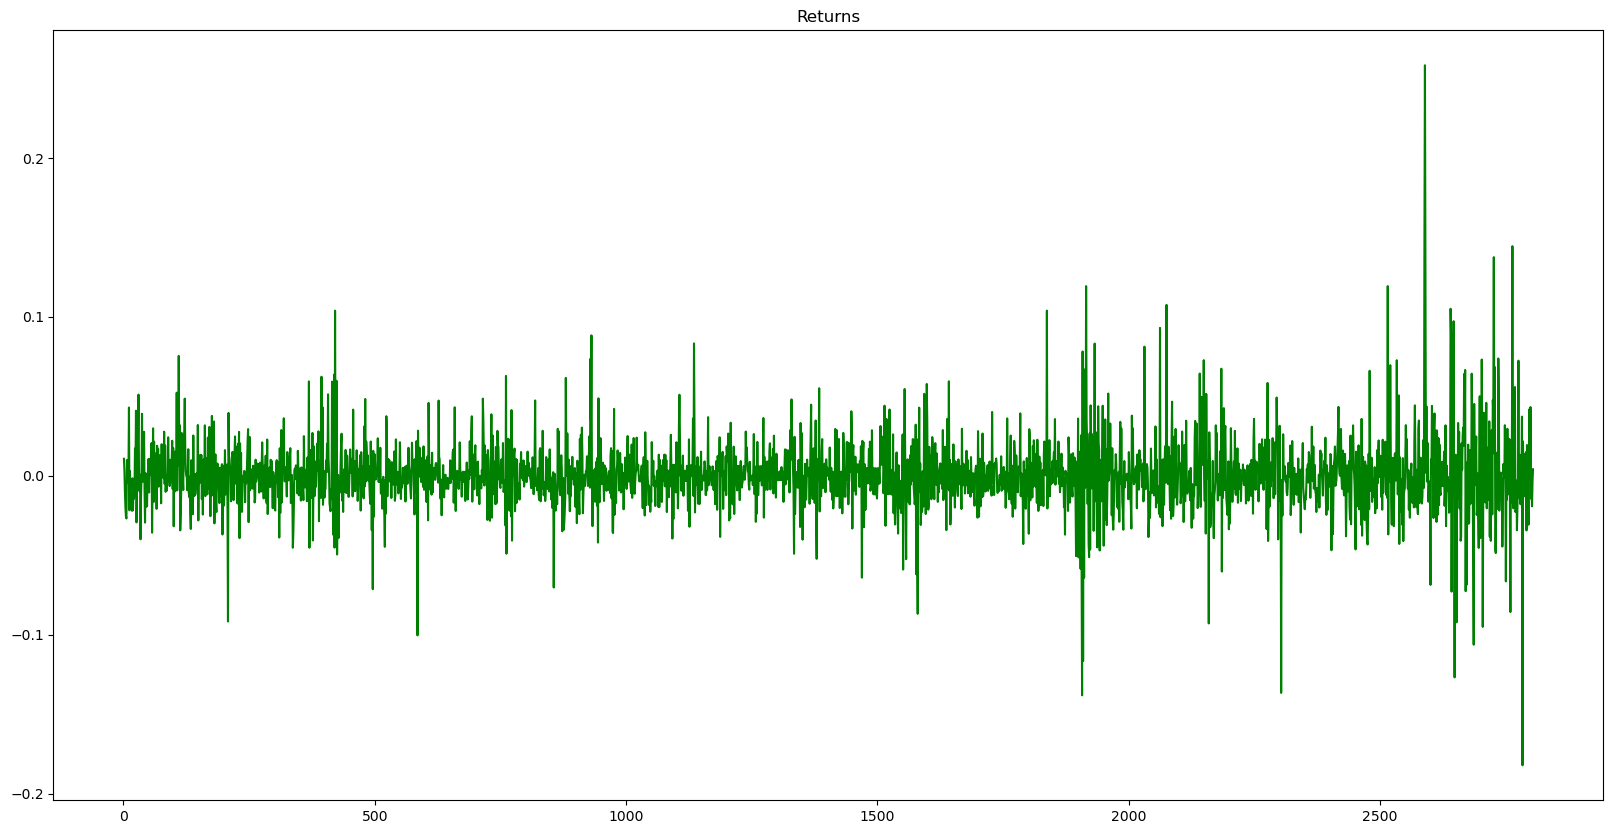

In [23]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (20,10))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [24]:
# train_test_split
train = mandf[:1042]
test = mandf[1042:]

length of mandf = 2085

##  Time Series Analysis and Stationarity Test


### Dickey-Fuller Test

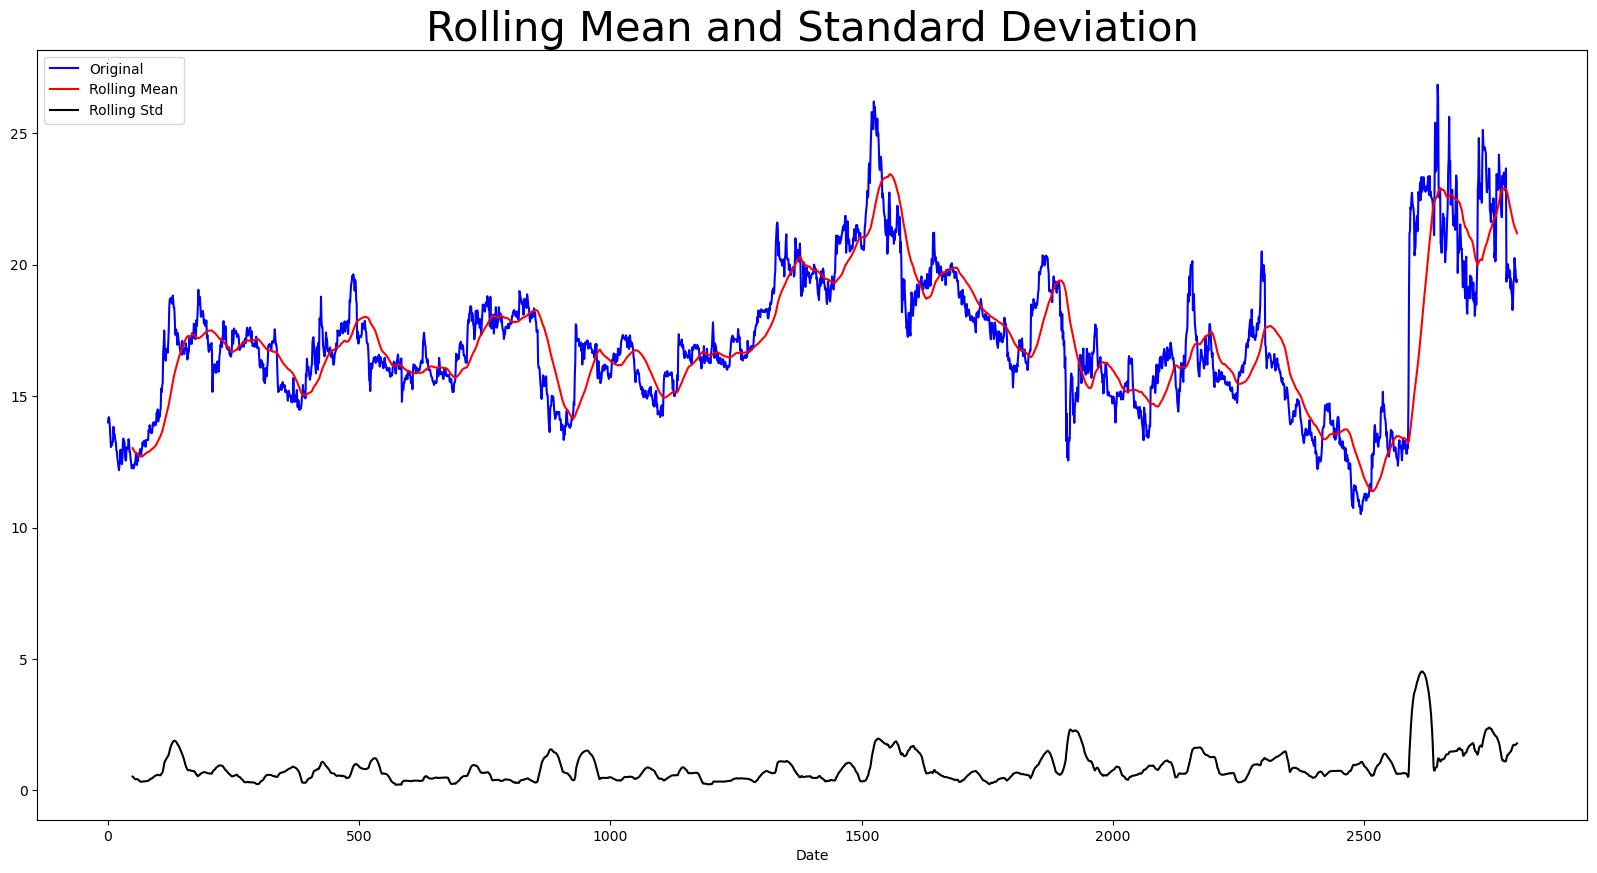

Results of Dickey-Fuller Test:
ADF Test Statistic: -3.776500254761722
p-value: 0.0031571097600893053
# Lags Used: 9
Number of Observations Used: 2795
Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data is stationary.


In [25]:
def test_stationarity(timeseries):
    # Calculate rolling statistics (rolling mean and rolling standard deviation)
    rolmean = timeseries.rolling(window=50).mean()
    rolstd = timeseries.rolling(window=50).std()

    # Plot rolling statistics
    plt.figure(figsize=(20, 10))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.xlabel('Date')
    plt.legend()
    plt.title('Rolling Mean and Standard Deviation', fontsize=30)
    plt.show()

    # Perform the Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label + ': ' + str(value))
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data is stationary.")
    else:
        print("Weak evidence against null hypothesis, time series is non-stationary.")

# Call the function with your time series data
test_stationarity(mandf['Close'])

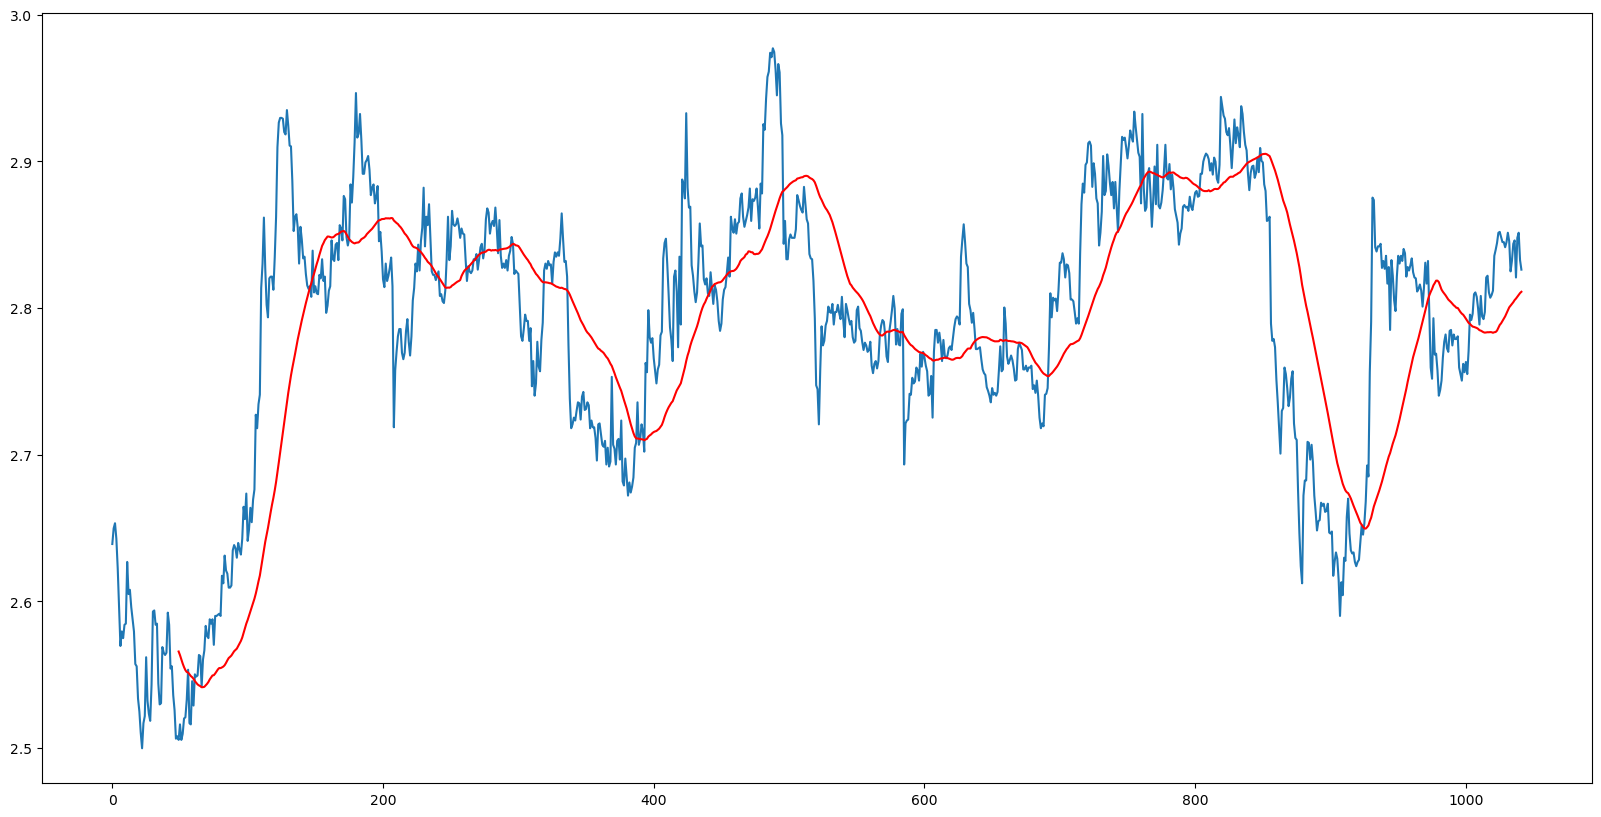

In [27]:
train_log = np.log(train['Close'])  # converting test and train into train log and test log values
test_log = np.log(test['Close'])

mav = train_log.rolling(50).mean() 
plt.figure(figsize = (20,10))
plt.plot(train_log) 
plt.plot(mav, color = 'red')

As the time series data is stationary there is no need to apply log, differentiation or any other method.
I have found out the train_log and test_log just so others could understand the use case.Also, we are using train_log and test_log to find the prediction value using arima model.

## Auto arima for prediction

In [28]:
import pmdarima as pm
from pmdarima import auto_arima

In [29]:
from pmdarima.arima import auto_arima

# Fit the auto_arima model
model = auto_arima(train_log, trace=True, error_action='ignore', suppress_warnings=True)

# Generate predictions with the fitted model
predictions = model.predict(n_periods=len(test))

# Ensure predictions have the same length as the test data
if len(predictions) != len(test):
    raise ValueError("The lengths of 'predictions' and 'test' do not match.")


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5460.136, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5458.484, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5464.133, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5463.556, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5460.375, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5463.541, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5463.201, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5461.541, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5466.004, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5465.422, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5465.077, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5465.427, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5463.422, Time=0.22 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.240 seconds


In [30]:
len(predictions)

1763

In [31]:
len(test_log)

1763

## Error Calculation

In [33]:
#Calculating error
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

RMSE :  0.17539722634674296


# Textual analysis

In [34]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [35]:
#Adding subjectivity and polarity columns
ndf['Subjectivity'] = ndf['headline_text'].apply(getSubjectivity)
ndf['Polarity'] = ndf['headline_text'].apply(getPolarity)
ndf

,Date,headline_text,Subjectivity,Polarity
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485
...,...,...,...,...
7712,2022-03-27,Playing a dead man in Body God meant sitting i...,0.365123,0.034162
7713,2022-03-28,As fashion becomes democratic demand for styl...,0.383007,0.058513
7714,2022-03-29,Bobby Deol Like my dad I hope to be working ...,0.403627,0.092144
7715,2022-03-30,I will not give in to trends Dossmode The tim...,0.344136,0.039954


In [36]:
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

In [37]:
ndf['sentiment_scores'] = ndf['headline_text'].apply(lambda x: sia.polarity_scores(x))

# Extract individual sentiment scores from the dictionary
ndf['Compound'] = ndf['sentiment_scores'].apply(lambda x: x['compound'])
ndf['Negative'] = ndf['sentiment_scores'].apply(lambda x: x['neg'])
ndf['Neutral'] = ndf['sentiment_scores'].apply(lambda x: x['neu'])
ndf['Positive'] = ndf['sentiment_scores'].apply(lambda x: x['pos'])



In [38]:
# Drop the temporary 'sentiment_scores' column if you don't need it
ndf.drop('sentiment_scores', axis=1, inplace=True)
ndf

,Date,headline_text,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024,0.9645,0.142,0.694,0.164
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,-0.8316,0.214,0.655,0.131
...,...,...,...,...,...,...,...,...
7712,2022-03-27,Playing a dead man in Body God meant sitting i...,0.365123,0.034162,-0.9999,0.158,0.758,0.084
7713,2022-03-28,As fashion becomes democratic demand for styl...,0.383007,0.058513,-0.9999,0.160,0.737,0.103
7714,2022-03-29,Bobby Deol Like my dad I hope to be working ...,0.403627,0.092144,-0.9999,0.159,0.755,0.086
7715,2022-03-30,I will not give in to trends Dossmode The tim...,0.344136,0.039954,-0.9999,0.156,0.769,0.076


## Merging the textual and historical data

In [39]:
df_merge = pd.merge(mandf, ndf, how='inner', on='Date')
df_merge

,Date,Open,High,Low,Close,Adj Close,Volume,headline_text,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2012-10-08,14.050000,14.20,14.000000,14.000000,12.978291,31846200.0,When villain became male lead Pooja's mum to m...,0.387560,0.065707,-0.9996,0.143,0.741,0.115
1,2012-08-13,13.970000,15.27,13.960000,14.150000,13.117345,2061800.0,When Karan Johar was sued How to get the subtl...,0.397394,0.090986,-0.9990,0.151,0.719,0.131
2,2012-08-14,14.200000,14.48,14.150000,14.200000,13.163694,204800.0,London Olympics I had to get this one af...,0.375891,0.040509,-0.9999,0.180,0.710,0.110
3,2012-08-15,14.420000,14.88,14.030000,14.050000,13.024641,563500.0,In pics Amazing patriotic face paints Indian ...,0.383965,0.053698,-0.9996,0.167,0.692,0.141
4,2012-08-16,14.070000,14.08,13.290000,13.770000,12.765076,1605600.0,Do Indian women need vagina tightening gel Sa...,0.426102,0.064899,-0.9993,0.165,0.692,0.144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2420,2022-01-11,13.260000,13.48,13.070000,13.110000,13.110000,192200.0,Vaikuntha Ekadashi Check date time si...,0.388525,0.071044,-0.9998,0.147,0.749,0.104
2421,2022-02-11,13.100000,13.10,12.770000,12.870000,12.870000,269700.0,Chaithra Kotoor took cues from a real cop to p...,0.353223,0.043691,-0.9999,0.152,0.751,0.098
2422,2022-03-11,12.730000,12.84,12.550000,12.560000,12.560000,181300.0,Powerism A song tribute to Puneeth on his bir...,0.381354,0.071642,-0.9997,0.147,0.750,0.103
2423,2022-01-12,21.799999,23.35,21.639999,22.559999,22.559999,2823800.0,Makar Sankranti Check date rituals and ...,0.389878,0.041324,-0.9999,0.160,0.742,0.098


## Create Dataset for Model Training

In [40]:
dfmerge1 = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']]
dfmerge1

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,14.000000,0.387560,0.065707,-0.9996,0.143,0.741,0.115
1,14.150000,0.397394,0.090986,-0.9990,0.151,0.719,0.131
2,14.200000,0.375891,0.040509,-0.9999,0.180,0.710,0.110
3,14.050000,0.383965,0.053698,-0.9996,0.167,0.692,0.141
4,13.770000,0.426102,0.064899,-0.9993,0.165,0.692,0.144
...,...,...,...,...,...,...,...
2420,13.110000,0.388525,0.071044,-0.9998,0.147,0.749,0.104
2421,12.870000,0.353223,0.043691,-0.9999,0.152,0.751,0.098
2422,12.560000,0.381354,0.071642,-0.9997,0.147,0.750,0.103
2423,22.559999,0.389878,0.041324,-0.9999,0.160,0.742,0.098


## Normalize the Data

In [41]:
scaler = MinMaxScaler()

df = pd.DataFrame(scaler.fit_transform(dfmerge1))
df.columns = dfmerge1.columns
df.index = dfmerge1.index
df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.197368,0.427725,0.449081,0.00020,0.436620,0.405941,0.520
1,0.207237,0.494290,0.595841,0.00050,0.492958,0.297030,0.648
2,0.210526,0.348738,0.302787,0.00005,0.697183,0.252475,0.480
3,0.200658,0.403389,0.379360,0.00020,0.605634,0.163366,0.728
4,0.182237,0.688612,0.444390,0.00035,0.591549,0.163366,0.752


In [42]:
X=df.drop('Close',axis=1)
X

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.427725,0.449081,0.00020,0.436620,0.405941,0.520
1,0.494290,0.595841,0.00050,0.492958,0.297030,0.648
2,0.348738,0.302787,0.00005,0.697183,0.252475,0.480
3,0.403389,0.379360,0.00020,0.605634,0.163366,0.728
4,0.688612,0.444390,0.00035,0.591549,0.163366,0.752
...,...,...,...,...,...,...
2420,0.434257,0.480062,0.00010,0.464789,0.445545,0.432
2421,0.195305,0.321263,0.00005,0.500000,0.455446,0.384
2422,0.385721,0.483538,0.00015,0.464789,0.450495,0.424
2423,0.443413,0.307522,0.00005,0.556338,0.410891,0.384


In [43]:
Y=df['Close']
Y

0       0.197368
1       0.207237
2       0.210526
3       0.200658
4       0.182237
          ...   
2420    0.138816
2421    0.123026
2422    0.102632
2423    0.760526
2424    0.771710
Name: Close, Length: 2425, dtype: float64

## Spliting the data to train and test 

In [44]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)
x_train.shape

(1940, 6)

# RandomForestRegressor Model

In [45]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [46]:
print(prediction[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(prediction,y_test))

[0.35464471 0.50787496 0.35415129 0.4402434  0.44015785 0.30132893
 0.40133552 0.39987497 0.59835519 0.3774539 ]
1490    0.684210
387     0.263158
1419    0.575658
410     0.390790
482     0.498026
93      0.198026
911     0.186842
979     0.313158
1362    0.578947
170     0.409210
Name: Close, dtype: float64
Mean Squared error:  0.017058613441161566


# DecisionTreeRegressor Model

In [47]:
dtr = DecisionTreeRegressor()
dtr.fit(x_train, y_train)
predictions = dtr.predict(x_test)

In [48]:
print(predictions[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(predictions,y_test))

[0.57894726 0.41184208 0.38552636 0.37828945 0.68092101 0.19407893
 0.47236839 0.2236842  0.74342094 0.40197372]
1490    0.684210
387     0.263158
1419    0.575658
410     0.390790
482     0.498026
93      0.198026
911     0.186842
979     0.313158
1362    0.578947
170     0.409210
Name: Close, dtype: float64
Mean Squared error:  0.03539871773068824


# AdaBoostRegressor Model

In [49]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)

AdaBoostRegressor()

In [50]:
predictions = adb.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.017177996453883536


# XGBRegressor Model

In [51]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [52]:
predictions = xgb.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.019741810003853815


## Line Chart

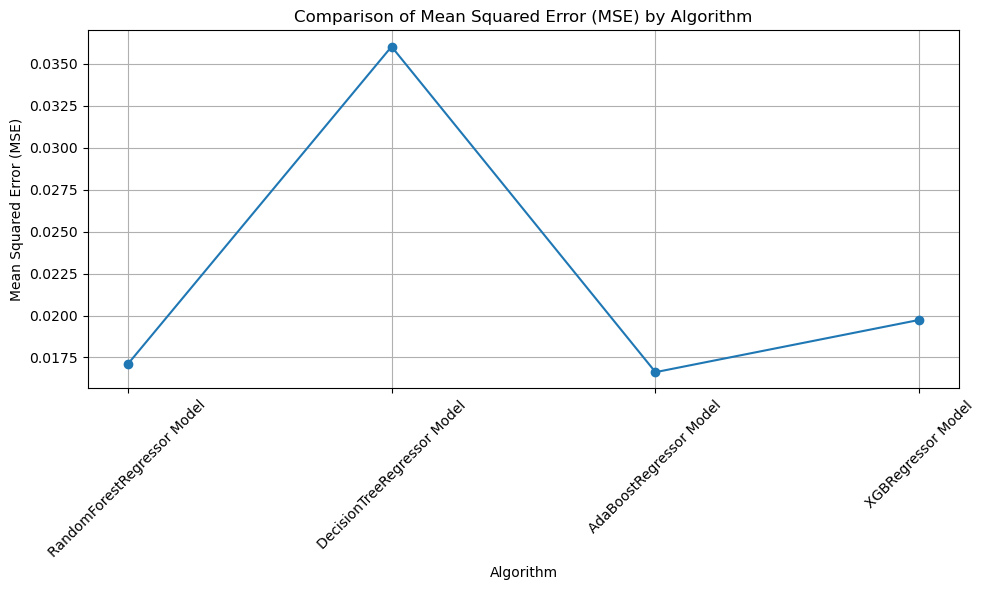

In [53]:
# Create a DataFrame with algorithm names and their corresponding MSE values
data = {
    'Algorithm': ['RandomForestRegressor Model', 'DecisionTreeRegressor Model', 'AdaBoostRegressor Model', 'XGBRegressor Model'],
    'MSE': [0.0170895045298339, 0.03602879063947368, 0.016624159007510922, 0.019741810003853815]  # Replace with your actual MSE values
}

df = pd.DataFrame(data)

# Create a line chart to compare MSE values
plt.figure(figsize=(10, 6))
plt.plot(df['Algorithm'], df['MSE'], marker='o', linestyle='-')
plt.title('Comparison of Mean Squared Error (MSE) by Algorithm')
plt.xlabel('Algorithm')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Display the chart
plt.tight_layout()
plt.show()




## Heat map

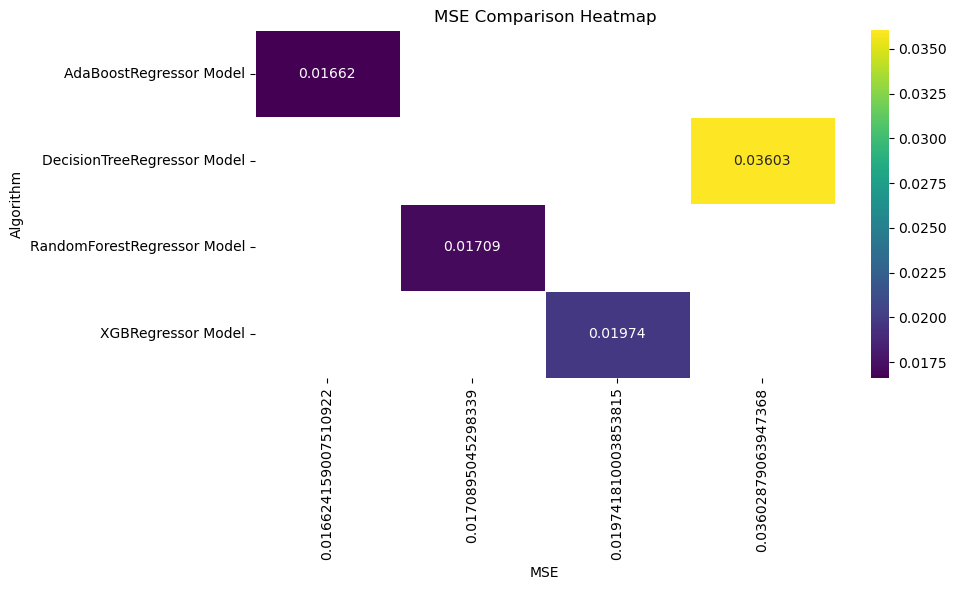

In [54]:
df_algorithm = pd.DataFrame(data)

# Reshape the data for the heatmap (Algorithm as rows, MSE as columns)
heatmap_data = df.pivot(index='Algorithm', columns='MSE', values='MSE')

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".5f", linewidths=0.5)
plt.title('MSE Comparison Heatmap')
plt.xlabel('MSE')
plt.ylabel('Algorithm')

# Display the heatmap
plt.tight_layout()
plt.show()

## SARIMAX

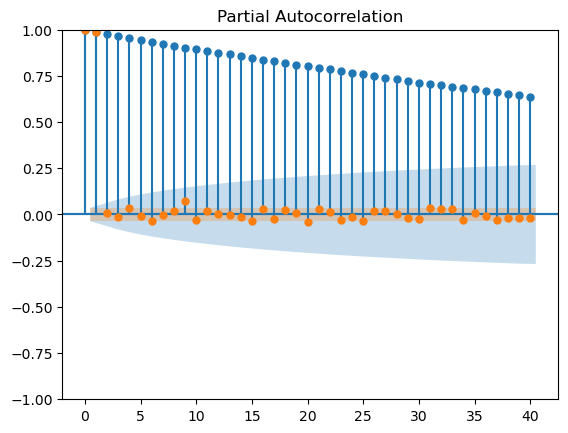

In [55]:
plot_acf(mandf['Close'], lags=40, ax=plt.gca())
plot_pacf(mandf['Close'], lags=40, ax=plt.gca())
plt.show()

In [56]:
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12  # Seasonal orders for monthly data

# Create and fit the SARIMA model
S_model = SARIMAX(mandf['Close'], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = S_model.fit()

In [57]:
# Define the number of future periods to predict
forecast_periods = 158  # Example: Predict 12 months into the future

# Make predictions
forecast = results.get_forecast(steps=forecast_periods)

# Extract the predicted values and associated confidence intervals
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()


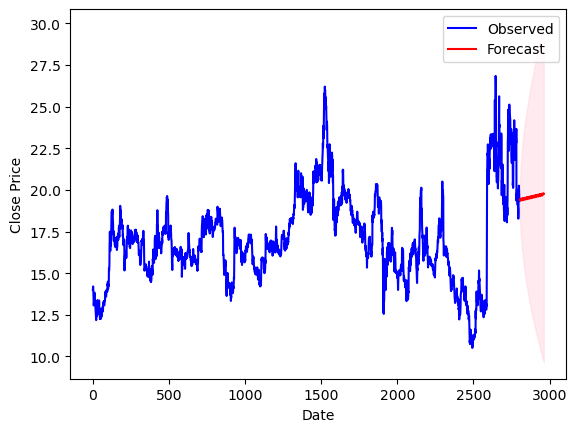

In [58]:
import matplotlib.pyplot as plt

# Plot the observed data
plt.plot(mandf.index, mandf['Close'], label='Observed', color='blue')

# Plot the predicted values
plt.plot(forecast_mean.index, forecast_mean.values, label='Forecast', color='red')

# Fill between the confidence intervals
plt.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()
